In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=multiprocessing.cpu_count())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=multiprocessing.cpu_count())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    print("Training on gpu")
    mode = 'cuda'
else:
    print("Training on cpu")
    mode = 'cpu'

Training on gpu


# Exercise 1. Convolutional Neural Networks (CNN)

In [3]:
class ResNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        if is_last:
            self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(2, 2), bias=False)
        else:
            self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if in_channels != out_channels:
            self.upsample_filters = True
            self.transform_skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), padding=(0, 0), stride=(1, 1), bias=False)
            self.transform_skip_bn   = nn.BatchNorm2d(out_channels)
        else:
            self.upsample_filters = False
        if is_last:
            self.transform_skip_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1), padding=(0, 0), stride=(2, 2), bias=False)
            self.transform_skip_bn = nn.BatchNorm2d(out_channels)
        self.is_last = is_last
        
    def forward(self, x):
        x_skip = x
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.bn2(x)
        
        if self.upsample_filters:
            x_skip = self.transform_skip_conv(x_skip)
            x_skip = torch.nn.functional.relu(x_skip)
            x_skip = self.transform_skip_bn(x_skip)
        
        x = x + x_skip
        x_skip = x
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        x = self.bn4(x)
        
        if self.is_last:
            x_skip = self.transform_skip_conv(x_skip)
            x_skip = torch.nn.functional.relu(x_skip)
            x_skip = self.transform_skip_bn(x_skip)
        
        x = x + x_skip
        
        return x



class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n):
        super().__init__()
        layers = []
        layers.append(ResNetBasicBlock(in_channels, out_channels, is_last=False))
        for j in range(2 * n - 2):
            layers.append(ResNetBasicBlock(out_channels, out_channels, is_last=False))
        layers.append(ResNetBasicBlock(out_channels, out_channels, is_last=True))
        self.seq = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.seq(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, in_channels, n):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(1024, 10)
        self.flatten = nn.Flatten()
        self.rn_block1 = ResNetBlock(16, 16 * (2 ** 0), n)
        self.rn_block2 = ResNetBlock(16 * (2 ** 0), 16 * (2 ** 1), n) 
        self.rn_block3 = ResNetBlock(16 * (2 ** 1), 16 * (2 ** 2), n)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.bn1(x)
        x = self.rn_block1(x)
        x = self.rn_block2(x)
        x = self.rn_block3(x)
        x = self.flatten(x) 
        x = self.fc(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

        
clf = ResNet(in_channels=3, n=1).to(mode)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.002, momentum=0.9)

In [4]:
num_epochs = 20

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # epoch
    total_train_loss = 0
    total_train_acc = 0
    train_iterations = 0
    for x, y in tqdm(trainloader):
        optimizer.zero_grad()
        x, y = x.to(mode), y.to(mode)
        y_pred = clf(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        acc = (torch.argmax(y_pred, dim=1) == y).sum().item() / y.shape[0]
        total_train_acc += acc
        train_iterations += 1

    total_val_loss = 0
    total_val_acc = 0
    test_iterations = 0
    for x, y in tqdm(testloader):
        x, y = x.to(mode), y.to(mode)
        with torch.no_grad():
            y_pred = clf(x)
            acc = (torch.argmax(y_pred, dim=1) == y).sum().item() / y.shape[0]
            loss = criterion(y_pred, y)
            total_val_acc += acc
            total_val_loss += loss.item()
        test_iterations += 1
    
    
    train_losses.append(total_train_loss / train_iterations)
    train_accs.append(total_train_acc / train_iterations)
    val_losses.append(total_val_loss / test_iterations)
    val_accs.append(total_val_acc / test_iterations)
    
    print(f"train loss at epoch {epoch}: {train_losses[-1]}")
    print(f"val loss at epoch {epoch}: {val_losses[-1]}")
    print(f"train acc at epoch {epoch}: {train_accs[-1]}")
    print(f"val acc at epoch {epoch}: {val_accs[-1]}")
    

  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 1: 2.165030762362663
val loss at epoch 1: 2.0518578185310847
train acc at epoch 1: 0.2894221547314578
val acc at epoch 1: 0.409315664556962


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 2: 2.0046993344641098
val loss at epoch 2: 1.9659567060349863
train acc at epoch 2: 0.46051390664961633
val acc at epoch 2: 0.5032634493670886


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 3: 1.9355430301193082
val loss at epoch 3: 1.9235815473749667
train acc at epoch 3: 0.5323049872122761
val acc at epoch 3: 0.5409414556962026


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 4: 1.8892743136266918
val loss at epoch 4: 1.8941476345062256
train acc at epoch 4: 0.5788043478260869
val acc at epoch 4: 0.5706091772151899


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 5: 1.8512547653349465
val loss at epoch 5: 1.8727712540686885
train acc at epoch 5: 0.6188459079283888
val acc at epoch 5: 0.5900909810126582


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 6: 1.8205131176487563
val loss at epoch 6: 1.856243285951735
train acc at epoch 6: 0.6506034207161125
val acc at epoch 6: 0.6081882911392406


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 7: 1.7942005316619678
val loss at epoch 7: 1.8461398157892348
train acc at epoch 7: 0.6766783887468031
val acc at epoch 7: 0.6203520569620253


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 8: 1.7697113917001983
val loss at epoch 8: 1.8312387345712395
train acc at epoch 8: 0.703684462915601
val acc at epoch 8: 0.6329113924050633


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 9: 1.748166630030288
val loss at epoch 9: 1.8241908791698986
train acc at epoch 9: 0.7260070332480818
val acc at epoch 9: 0.638943829113924


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 10: 1.7289032103765347
val loss at epoch 10: 1.8158510093447529
train acc at epoch 10: 0.745696131713555
val acc at epoch 10: 0.6498219936708861


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 11: 1.7077490033396066
val loss at epoch 11: 1.81572524958019
train acc at epoch 11: 0.7680226982097187
val acc at epoch 11: 0.6488330696202531


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 12: 1.6908708996784962
val loss at epoch 12: 1.80819847915746
train acc at epoch 12: 0.7845348465473146
val acc at epoch 12: 0.6573378164556962


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 13: 1.673906671421607
val loss at epoch 13: 1.8078153736983673
train acc at epoch 13: 0.8019301470588235
val acc at epoch 13: 0.6556566455696202


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 14: 1.6581817944641308
val loss at epoch 14: 1.80682488181923
train acc at epoch 14: 0.8177709398976982
val acc at epoch 14: 0.6599090189873418


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 15: 1.6433354616165161
val loss at epoch 15: 1.7990447961831395
train acc at epoch 15: 0.8322650255754475
val acc at epoch 15: 0.6620846518987342


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 16: 1.6310924206243451
val loss at epoch 16: 1.801504390149177
train acc at epoch 16: 0.8437260230179029
val acc at epoch 16: 0.6613924050632911


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 17: 1.6195075603397302
val loss at epoch 17: 1.7992937278143968
train acc at epoch 17: 0.8553908248081841
val acc at epoch 17: 0.6624802215189873


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 18: 1.6083376316158362
val loss at epoch 18: 1.794998967194859
train acc at epoch 18: 0.8657368925831203
val acc at epoch 18: 0.6682159810126582


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 19: 1.5970504698546037
val loss at epoch 19: 1.7948844674267346
train acc at epoch 19: 0.8761468989769822
val acc at epoch 19: 0.6678204113924051


100%|██████████| 79/79 [00:01<00:00, 63.84it/s]

train loss at epoch 20: 1.5889104065077995
val loss at epoch 20: 1.7930983953838107
train acc at epoch 20: 0.8828045076726342
val acc at epoch 20: 0.6685126582278481


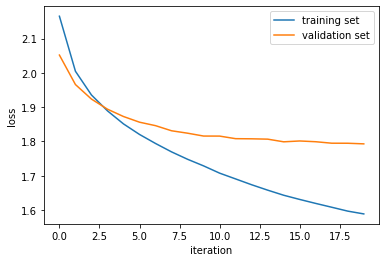

In [5]:
plt.plot(list(range(len(train_losses))), train_losses, label="training set")
plt.plot(list(range(len(val_losses))), val_losses, label="validation set")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

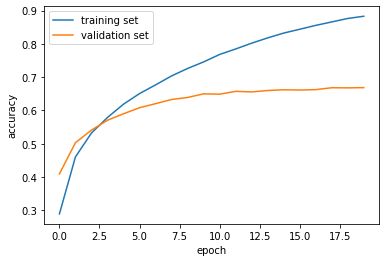

In [6]:
plt.plot(list(range(len(train_accs))), train_accs, label="training set")
plt.plot(list(range(len(val_accs))), val_accs, label="validation set")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## (a) Plot the filters of the first layer. What kind of features do they extract?

In [15]:
def normalise(x):
    minimum = np.min(x)
    maximum = np.max(x)
    return (x - minimum) / (maximum - minimum)
    
def normalise_img(img):
    img[:,:,0] = normalise(img[:,:,0])
    img[:,:,1] = normalise(img[:,:,1])
    img[:,:,2] = normalise(img[:,:,2])
    return img

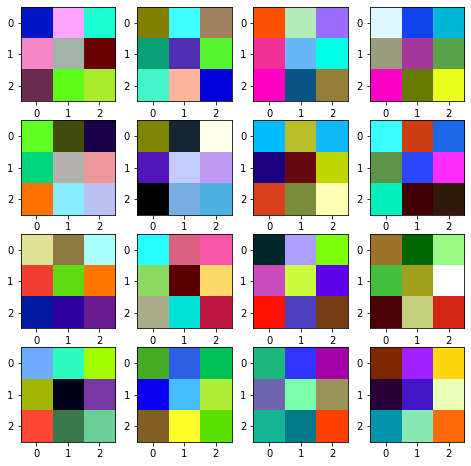

In [16]:
filters = clf.conv1.weight.detach().cpu().clone().numpy()

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = normalise_img(filters[i - 1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## c) Is deeper always better? Provide some evidence for your answer and explain why that is the case.

In theory it should be better, since our network can learn more complex functions, however in practise it makes the network overfit faster, makes the network suffer from the vanishing gradient problem and increases computational complexity.